# CNN for Flower Dataset

## 載入模組

In [1]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## 載入 CIFAR10 資料集

In [2]:
batch_size = 100

# 標準化
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)


Extracting data\cifar-10-python.tar.gz to data
Files already downloaded and verified


## 資料分割

In [4]:
test_size = 0.2
idx = list(range(len(train_data)))
np.random.shuffle(idx)
split_size = int(np.floor(test_size * len(train_data)))
train_idx, dev_idx = idx[split_size:], idx[:split_size]

train_sampler = SubsetRandomSampler(train_idx)
dev_sampler = SubsetRandomSampler(dev_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
dev_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=dev_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [19]:
# 圖片的維度：顏色通道、寬、高
train_data[0][0].shape

torch.Size([3, 32, 32])

## GPU / CPU 判斷

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 計算Conv2D/Pool2D 轉換後的圖片寬度

In [1]:
import math

# W, F, P, S：image Width, Filter width, Padding, Stride 
# def Conv_Width(W, F, P, S):
#     return math.floor(((W - F) + 2 * P) / S) + 1

# def Pool_Width(W, F, S):
#     return math.floor((W - F) / S) + 1

def Conv_Width(W, F, P, S):
    return math.floor(((W - F + 2 * P) / S) + 1)

def Pool_Width(W, F, S):
    return math.floor((W - F) / S + 1)

# test
print(Pool_Width(Conv_Width(32, 3, 1, 1), 2, 2))
print(Pool_Width(Conv_Width(16, 3, 1, 1), 2, 2))
print(Pool_Width(Conv_Width(8, 3, 1, 1), 2, 2))

def Conv_Pool_Width(W, F, P, S, F2, S2, n):
    for i in range(n):
        W = Pool_Width(Conv_Width(W, F, P, S), F2, S2)
    return W

Conv_Pool_Width(32, 3, 1, 1, 2, 2, 3)

16
8
4


4

## 建立神經網路模型

In [38]:
Adjusted_width = Conv_Pool_Width(32, 3, 1, 1, 2, 2, 3)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Conv2d 參數： in-channel, out-channel, kernel size, Padding, Stride
        self.conv1 = nn.Conv2d(3, 10, 3, 1, 1)
        self.conv2 = nn.Conv2d(10, 20, 3, 1, 1)
        self.conv3 = nn.Conv2d(20, 40, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.linear1 = nn.Linear(40 * Adjusted_width * Adjusted_width, 100)
        self.linear2 = nn.Linear(100, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # flatten
        x = x.view(-1, 40 * Adjusted_width * Adjusted_width)
        
        x = self.dropout(x)
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        x = F.log_softmax(self.linear2(x), dim=1)
        
        return x

## 定義損失函數、優化器

In [39]:
model = CNN().to(device)
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50

## 訓練模型

In [40]:
model.train()

train_losses, dev_losses, train_acc, dev_acc= [], [], [], []
x_axis = []

for e in range(1, epochs+1):
    losses = 0
    acc = 0
    iterations = 0
    
    model.train()
    for data, target in train_loader:
        iterations += 1

        pred = model(data.to(device))
        loss = loss_function(pred, target.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses += loss.item()
        p = torch.exp(pred)
        top_p, top_class = p.topk(1, dim=1)
        acc += accuracy_score(target.to("cpu"), top_class.to("cpu"))
        
    dev_losss = 0
    dev_accs = 0
    iter_2 = 0
        
    if e%5 == 0 or e == 1:
        x_axis.append(e)
        
        with torch.no_grad():
            model.eval()
            
            for data_dev, target_dev in dev_loader:
                iter_2 += 1
                
                dev_pred = model(data_dev.to(device))
                dev_loss = loss_function(dev_pred, target_dev.to(device))
                dev_losss += dev_loss.item()

                dev_p = torch.exp(dev_pred)
                top_p, dev_top_class = dev_p.topk(1, dim=1)
                dev_accs += accuracy_score(target_dev.to("cpu"), dev_top_class.to("cpu"))
        
        train_losses.append(losses/iterations)
        dev_losses.append(dev_losss/iter_2)
        train_acc.append(acc/iterations)
        dev_acc.append(dev_accs/iter_2)
        
        print("Epoch: {}/{}  ".format(e, epochs),
              "Training Loss: {:.3f}  ".format(losses/iterations),
              "Validation Loss: {:.3f}  ".format(dev_losss/iter_2),
              "Training Accuracy: {:.3f}  ".format(acc/iterations),
              "Validation Accuracy: {:.3f}".format(dev_accs/iter_2))

Epoch: 1/50   Training Loss: 1.735   Validation Loss: 1.477   Training Accuracy: 0.364   Validation Accuracy: 0.464
Epoch: 5/50   Training Loss: 1.174   Validation Loss: 1.100   Training Accuracy: 0.581   Validation Accuracy: 0.606
Epoch: 10/50   Training Loss: 0.977   Validation Loss: 0.965   Training Accuracy: 0.656   Validation Accuracy: 0.659
Epoch: 15/50   Training Loss: 0.870   Validation Loss: 0.893   Training Accuracy: 0.690   Validation Accuracy: 0.680
Epoch: 20/50   Training Loss: 0.806   Validation Loss: 0.859   Training Accuracy: 0.713   Validation Accuracy: 0.697
Epoch: 25/50   Training Loss: 0.754   Validation Loss: 0.835   Training Accuracy: 0.729   Validation Accuracy: 0.707
Epoch: 30/50   Training Loss: 0.720   Validation Loss: 0.812   Training Accuracy: 0.739   Validation Accuracy: 0.712
Epoch: 35/50   Training Loss: 0.678   Validation Loss: 0.821   Training Accuracy: 0.756   Validation Accuracy: 0.714
Epoch: 40/50   Training Loss: 0.655   Validation Loss: 0.809   Tra

## 損失函數畫圖

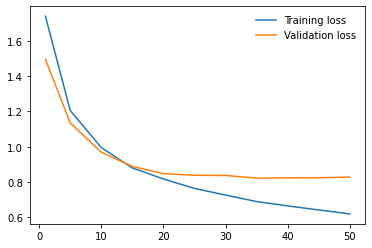

In [32]:
plt.plot(x_axis,train_losses, label='Training loss')
plt.plot(x_axis, dev_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

## 準確率畫圖

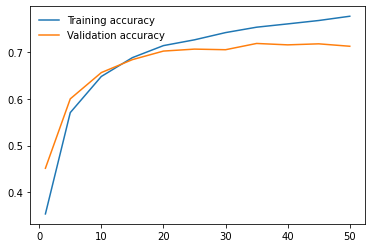

In [33]:
plt.plot(x_axis, train_acc, label="Training accuracy")
plt.plot(x_axis, dev_acc, label="Validation accuracy")
plt.legend(frameon=False)
plt.show()

## 模型評估

In [53]:
model.eval()
no = 0
acc_test = 0
for data_test, target_test in test_loader:
    no += 1
    test_pred = model(data_test.to(device))
    test_pred = torch.exp(test_pred)
    top_p, top_class_test = test_pred.topk(1, dim=1)
    # sklearn 只能在 cpu 計算
    acc_test += accuracy_score(target_test.to("cpu"), top_class_test.to("cpu"))

print('Test Accuracy: %.2f'%(acc_test*100/no))    

Test Accuracy: 72.08


## 模型評估 方法2

In [49]:
# compute accuracy
def get_accuracy(logit, target):
    ''' Obtain accuracy for training round '''
    batch_size = len(target)
#     corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    corrects = (torch.max(logit, 1)[1].data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [50]:
no = 0
acc_test = 0
for data_test, target_test in test_loader:
    no += 1
    test_pred = model(data_test.to(device))
    acc_test += get_accuracy(test_pred, target_test.to(device))
    
print('Test Accuracy: %.2f'%(acc_test/no))    

Test Accuracy: 72.08
